In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

from src.emotion.analysis.feature_generator import FeatureGenerator, VADGenerator

%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
emotions = ["Angry", "Disgust", "Happy", "Sad", "Surprise", "Fear", "Neutral"]
vad = ["Valence", "Arousal", "Dominance"]

In [4]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'short_clip_debug.csv')

In [5]:
features_pipeline = [VADGenerator()]

feature_generator = FeatureGenerator(features_pipeline)
feature_df = feature_generator.generate_features(df)

feature_df.head()

,Frame,ClassID,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,GazeDetections,Brightness,Valence,Arousal,Dominance
0,0,person_id1,0.887372,892.685791,143.625381,0.025781,0.016932,0.172089,0.042134,0.014512,0.244524,0.484028,[],143.574166,-0.157281,0.414772,-0.105719
1,0,person_id3,0.839904,222.598083,234.223846,0.000274,0.000251,0.033016,0.000770,0.142465,0.003232,0.819992,"['person_id2', 'person_id4']",143.574166,0.028489,0.178216,0.029037
2,0,person_id2,0.817095,476.264099,626.444702,0.006691,0.003427,0.002156,0.003466,0.000216,0.000438,0.983606,[],143.574166,-0.011866,0.006035,0.001516
3,0,person_id4,0.792489,911.343872,593.684570,0.019997,0.007032,0.007849,0.060943,0.430854,0.018796,0.454529,['person_id1'],143.574166,-0.098920,0.416553,-0.058925
4,5,person_id1,0.879774,888.616089,145.155823,0.003035,0.002635,0.220257,0.212025,0.024917,0.027109,0.510022,[],143.555228,-0.024547,0.063293,-0.018476


In [8]:
preprocessing_pipeline = [
    LinearInterpolator(),
    RollingAverageSmoother(
        window_size=150,
        cols=[*emotions, *vad],
    ),
]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(feature_df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,Valence,Arousal,Dominance,ClassID
0,0,0.887372,892.685791,143.625381,0.063272,0.034150,0.076438,0.125243,0.062755,0.061847,0.576295,143.574166,-0.208074,0.139069,-0.081530,person_id1
1,1,0.885853,891.871851,143.931470,0.062455,0.033711,0.075589,0.126996,0.062228,0.062026,0.576996,143.570378,-0.209599,0.135301,-0.084689,person_id1
2,2,0.884333,891.057910,144.237558,0.061660,0.033283,0.074769,0.128706,0.061718,0.062199,0.577665,143.566591,-0.211078,0.131640,-0.087758,person_id1
3,3,0.882813,890.243970,144.543646,0.060887,0.032866,0.073978,0.130373,0.061225,0.062366,0.578305,143.562803,-0.212514,0.128083,-0.090740,person_id1
4,4,0.881294,889.430029,144.849734,0.060134,0.032460,0.073215,0.132000,0.060748,0.062528,0.578915,143.559016,-0.213907,0.124624,-0.093639,person_id1


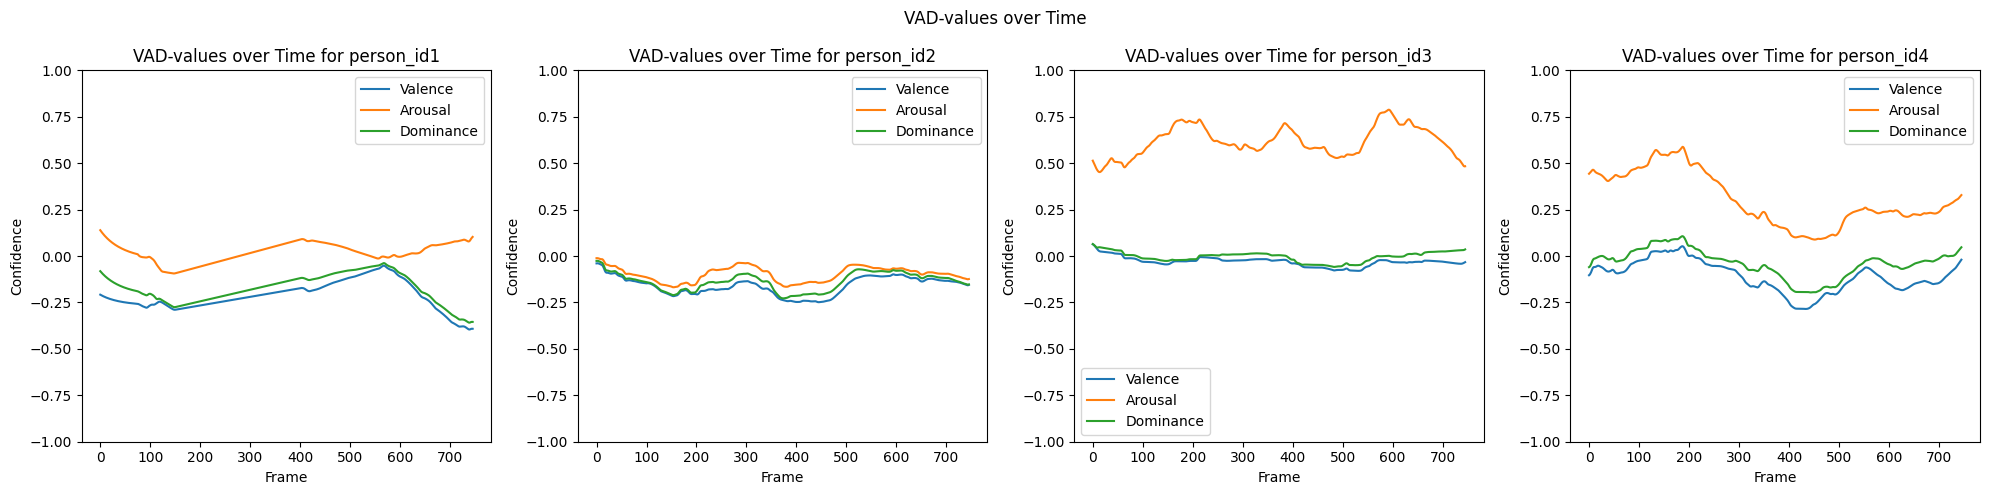

In [9]:
grouped = pre_df.groupby("ClassID")

fig = plt.figure(figsize=(20, 5), tight_layout=True)
fig.suptitle("VAD-values over Time")

for i, (person_id, group) in enumerate(grouped):
    emotions_rolling = group[["Frame", *vad]]

    ax = fig.add_subplot(1, 4, i + 1)
    emotions_rolling.plot(
        x="Frame",
        y=vad,
        ax=ax,
    )

    ax.set_title(f"VAD-values over Time for {person_id}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("Confidence")
    ax.set_ylim(-1, 1)

plt.show()

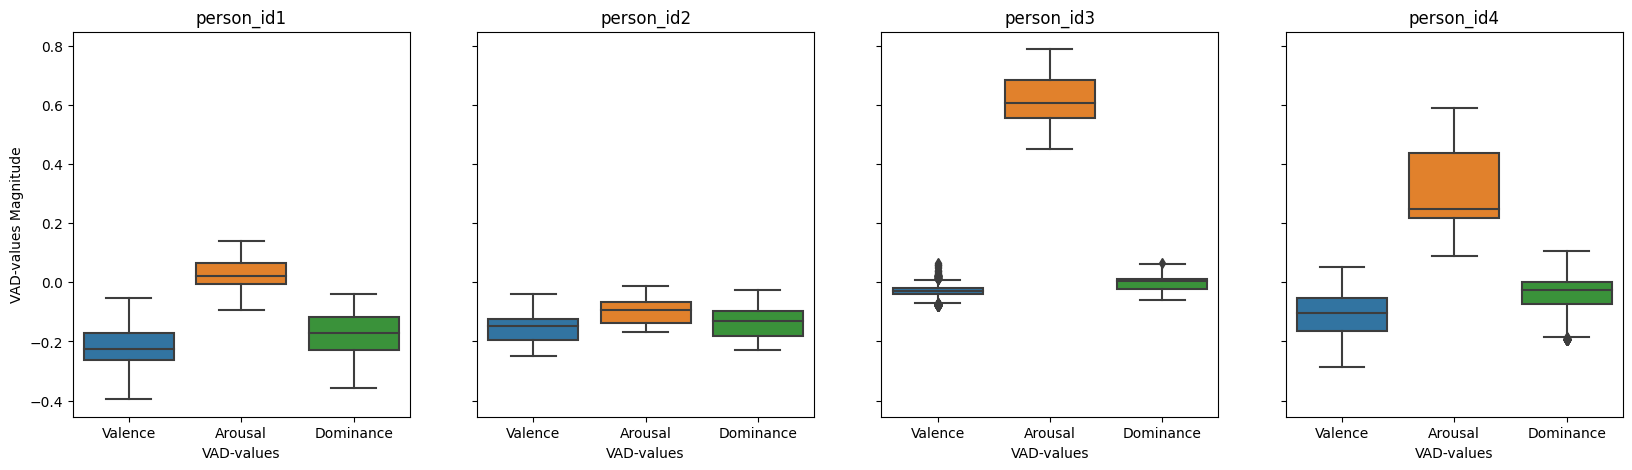

In [10]:
# Set the figure size
fig, axes = plt.subplots(1, len(pre_df['ClassID'].unique()), figsize=(20, 5), sharey=True)

# Loop over each ClassID and plot a boxplot for each emotion
for i, cid in enumerate(pre_df['ClassID'].unique()):
    # Subset the data for the current ClassID
    subset = pre_df[pre_df['ClassID'] == cid][vad]
    # Plot the boxplot for each emotion on a separate subplot
    sns.boxplot(data=subset, ax=axes[i])
    axes[i].set_title(f'{cid}')
    axes[i].set_xlabel('VAD-values')

# Set the y-axis label on the first subplot only
axes[0].set_ylabel('VAD-values Magnitude')

# Show the plot
plt.show()

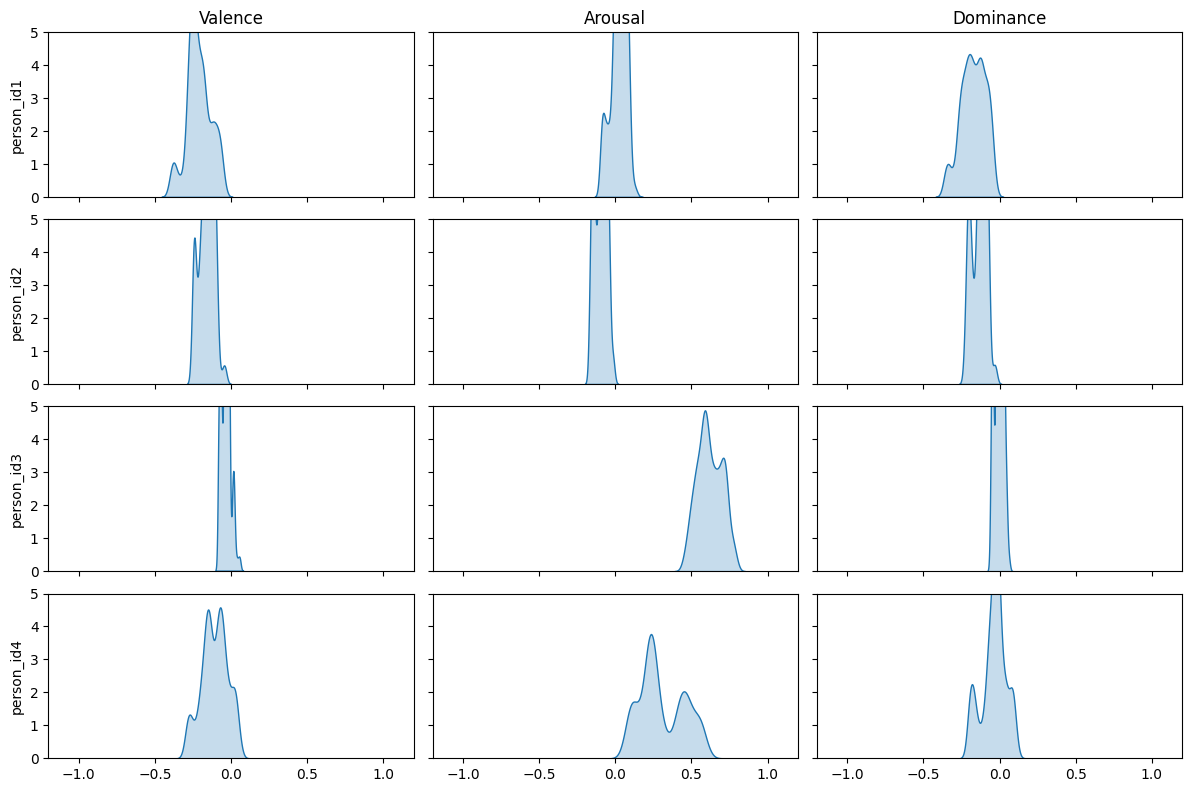

In [12]:
# Group the data by ClassID and emotion columns
grouped = pre_df.groupby(['ClassID', *vad]).size().reset_index(name='count')

# Define the size of the figure and the number of rows and columns
fig, axes = plt.subplots(nrows=len(grouped['ClassID'].unique()), ncols=len(vad), figsize=(12, 8), sharex=True, sharey=True)

# Set the x and y axis limits
xlim = (-1.2, 1.2)
ylim = (0, 5)

# Loop over each ClassID and emotion, and plot a distribution plot
for i, cid in enumerate(grouped['ClassID'].unique()):
    for j, e in enumerate(vad):
        sns.kdeplot(data=grouped[(grouped['ClassID'] == cid)], x=e, ax=axes[i, j], fill=True)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel(f'{cid}')
        if i == 0:
            axes[i, j].set_title(f'{e}')
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)

# Adjust the spacing between subplots
fig.tight_layout(pad=1)
plt.show()